# Summary

In this Phase 4 project, the objective was to develop a recommendation system using Jupyter Notebook. The project utilized a dataset containing 100,836 movie ratings and 3,683 tag applications across 9,742 movies. The data were generated by 610 users between March 29, 1996, and September 24, 2018.

The data preparation steps included merging multiple dataframes, such as movies, ratings, tags, and links, to create a consolidated dataset. Unnecessary columns were dropped, and missing values were handled appropriately. Descriptive statistics were analyzed to gain insights into the dataset.

Various packages and libraries were used, such as pandas, sklearn, surprise, matplotlib, and numpy. These packages provided essential functionality for data manipulation, modeling, and evaluation.

For modeling, the Surprise package was utilized, specifically the SVD model, which is an implementation of Funk's SVD. Cross-validation was performed to assess the model's performance, and the root mean square error (RMSE) was used as the evaluation metric.

The final model achieved an RMSE of 0.9501, indicating reasonably good performance. The recommendation system was able to provide estimated ratings for user-movie combinations.

The validation approach involved splitting the data into training and testing sets. The train_test_split function was used to create these sets, allowing for an assessment of the model's performance on unseen data.

In conclusion, this project successfully developed a recommendation system using the Surprise package and the SVD model. The system was able to make accurate predictions and provide personalized movie recommendations based on user ratings. The evaluation results demonstrated the effectiveness of the model in generating reliable recommendations.

# Importing the necessary packages

In [1]:
import pandas as pd
import ipywidgets as widgets
from IPython.display import display
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import mean_squared_error
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from surprise import Dataset, Reader, SVD, accuracy
from surprise.model_selection import cross_validate, train_test_split
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import numpy as np
from surprise import Dataset, Reader, SVD
from surprise.accuracy import rmse
from surprise.model_selection import cross_validate
from scipy.sparse import csr_matrix





# Reading and Cleaning Data

#### Creating dataframes for the data on 100836 movie ratings and 3683 tag applications across 9742 movies. The data were created by 610 users between March 29, 1996 and September 24, 2018. This dataset was generated on September 26, 2018.

In [82]:
Links= pd.read_csv('ml-latest-small/links.csv')
Movies= pd.read_csv('ml-latest-small/movies.csv')
Ratings= pd.read_csv('ml-latest-small/ratings.csv')
Tags= pd.read_csv('ml-latest-small/tags.csv')

In [83]:
RatingsandTags = Ratings.merge(Tags, on='movieId', how='left')
#merging the ratings and tags dataframe on movie id

In [84]:
MovieandLinks= Movies.merge(Links,on='movieId',how='left')
#merging the movies and links dataframe on movie id


In [46]:
DF = MovieandLinks.merge(RatingsandTags, right_on='movieId', left_on='movieId', how='outer')
#merging MovieandLinks and RatingsandTags
DF.drop_duplicates(subset=['title'], inplace=True)

#### Removing unnecessary data inclusion and resetting the index

In [86]:
DF3= DF2.drop(columns='tag')
DF4= DF3.drop(columns='userId_y')
DF5= DF4.reset_index()
DF5['rating']= DF5['rating'].dropna()

# Genre Seperation


#### Since the movies provided are described with multiple genres, a table was created to indicate which genres each movie belongs to. 1 indicated that the movie belongs to that genre with 0 indicated that the movie does not belong. 

In [356]:

genres = DF5['genres'].str.get_dummies('|') #seperating the genres by splitting on the vertical line 
movies_with_genres = pd.concat([DF5, genres], axis=1)
movies_with_genres.drop('genres', axis=1, inplace=True)# dropping original genere column (has become redundant)
movies_with_genres = movies_with_genres.drop(columns=['imdbId', 'tmdbId', '(no genres listed)'])


## Visualzing Top Genres
 

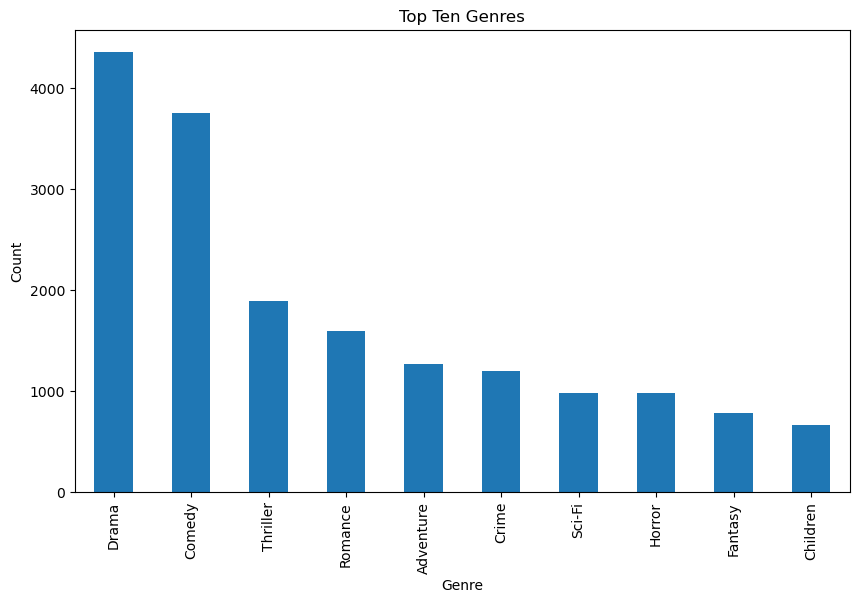

In [249]:
GenreCounts=movies_with_genres.drop(columns=['timestamp_x','rating'])
genre_counts = GenreCounts.iloc[:, 4:].sum().sort_values(ascending=False)

top_ten_genres = genre_counts.head(10)

plt.figure(figsize=(10, 6))
top_ten_genres.plot(kind='bar')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.title('Top Ten Genres')
plt.show()

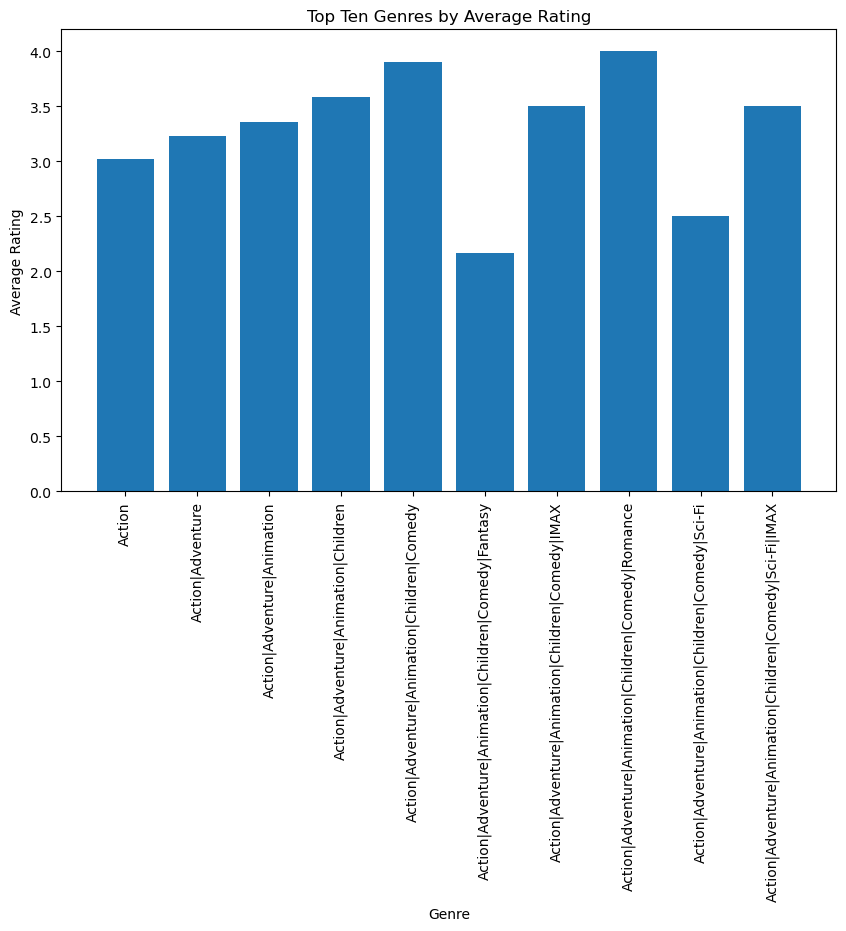

In [274]:
DF6 = DF5[DF5['genres'] != "(no genres listed)"]

average_ratings = DF6.groupby('genres')['rating'].mean()

top_ten_genres = average_ratings.head(10)

plt.figure(figsize=(10, 6))
plt.bar(top_ten_genres.index, top_ten_genres.values)
plt.xlabel('Genre')
plt.ylabel('Average Rating')
plt.title('Top Ten Genres by Average Rating')
plt.xticks(rotation=90)
plt.show()

In [264]:
average_ratings

genres
(no genres listed)                     3.397059
Action                                 3.025000
Action|Adventure                       3.234375
Action|Adventure|Animation             3.361111
Action|Adventure|Animation|Children    3.583333
                                         ...   
Sci-Fi|Thriller                        3.340909
Sci-Fi|Thriller|IMAX                   3.500000
Thriller                               2.945783
War                                    3.500000
Western                                3.608696
Name: rating, Length: 951, dtype: float64

# Creation of Pivot Table 
#### This table with only the ratings, user ids, and movie id. For the movies with no reviews a 0.0 was used as a placeholder

In [94]:

rating_pivot = DF5.pivot_table(values='rating', columns='userId_x', index='movieId').fillna(0)
rating_pivot

userId_x,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,600.0,601.0,603.0,604.0,605.0,606.0,607.0,608.0,609.0,610.0
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193581,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
193583,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
193585,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Visualizing number of ratings provided by each user, as well as the number of users. 

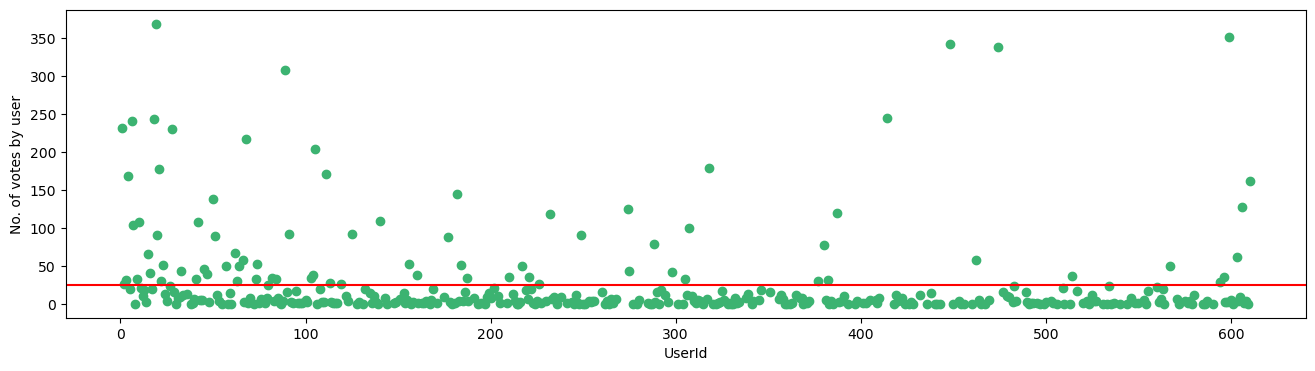

In [90]:
no_movies_voted = DF4.groupby('userId_x')['rating'].count() # Groups UserId with the number of their ratings
no_movies_voted_mean = no_movies_voted.mean()

f, ax = plt.subplots(1, 1, figsize=(16, 4))
plt.scatter(no_movies_voted.index, no_movies_voted, color='mediumseagreen')
plt.axhline(y=no_movies_voted_mean, color='r')
plt.xlabel('UserId')
plt.ylabel('No. of votes by user')
plt.show()






### This visuals shows that data has ratings from over 600 different users with each user giving around 25 reviews each (25.37597911227154 to be precise)

# Creation of Reccomendation System 

In [53]:
DF5['movieId'] = DF5['movieId'].astype('str')


user_rating_matrix = DF5.pivot(index='userId_x', columns='movieId', values='rating')

data = DF5[['userId_x', 'movieId', 'rating']]
reader = Reader()
data = Dataset.load_from_df(data, reader=reader)

model = SVD() #Use of Surprise's implementation of Funk's SVD


In [54]:

X = DF5[['userId_x', 'movieId', 'rating']]

X = X.loc[X['rating'].notna()]
X = X.reset_index().drop(columns = ['index'])

reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(X, reader)

alg = SVD()
cross_validate(alg, data, measures=['RMSE'], cv=3, verbose=True)

trainset, testset = train_test_split(data, test_size=0.25)
algo = SVD()
predictions = algo.fit(trainset).test(testset)
accuracy.rmse(predictions)



Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9361  0.9642  0.9428  0.9477  0.0120  
Fit time          0.05    0.04    0.04    0.05    0.01    
Test time         0.01    0.01    0.01    0.01    0.00    
RMSE: 0.9501


0.9500841368380837

In [55]:

svd = SVD(n_factors=100, n_epochs=10, lr_all=0.005, reg_all=0.4)
svd.fit(trainset)
predictions = svd.test(testset)
print(accuracy.rmse(predictions))

RMSE: 0.9715
0.971513276620624


In [347]:
from collections import defaultdict


def get_top_n(predictions, n=5):
    top_n = defaultdict(list)

    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n



In [334]:
predset = trainset.build_anti_testset() 

top_n = get_top_n(predictions, n=5) 

In [336]:
top10recs = pd.DataFrame([(uid, rec[0], rec[1]) for uid, recs in top_n.items() for rec in recs],
                         columns=['userId', 'movieId', 'estimated_rating'])
top10recs['movieId'] = top10recs['movieId'].astype(str)


In [348]:
merged_df = pd.concat([DF5[['userId_x', 'movieId', 'title']], top10recs[['estimated_rating']]], axis=1)

prediction = algo.predict('553', '9')

prediction

Prediction(uid='553', iid='9', r_ui=None, est=3.3066950198929894, details={'was_impossible': False})

In [343]:
lowest_rated_film = merged_df.loc[merged_df['estimated_rating'].idxmax()]
lowest_rated_film_title = merged_df.loc[merged_df['estimated_rating'].idxmax(), 'title']
lowest_rated_film_title


'Birdcage, The (1996)'

In [298]:
prediction = algo.predict('Waiting to Exhale  (1995)', '24')
prediction


Prediction(uid='Waiting to Exhale  (1995)', iid='24', r_ui=None, est=3.3066950198929894, details={'was_impossible': False})

In [32]:

prediction_df = pd.DataFrame(predictions, columns=['item_id','iid','r_ui','est','details'])
prediction_df2 = prediction_df.sort_values('item_id', ascending=True)

prediction_df2

,item_id,iid,r_ui,est,details
1449,1.0,2450,4.0,4.027378,{'was_impossible': False}
776,1.0,1804,5.0,4.027378,{'was_impossible': False}
451,1.0,2291,5.0,4.027378,{'was_impossible': False}
1394,1.0,2492,4.0,4.027378,{'was_impossible': False}
1309,1.0,2654,5.0,4.027378,{'was_impossible': False}
...,...,...,...,...,...
981,610.0,56620,3.0,3.450315,{'was_impossible': False}
457,610.0,78626,3.5,3.450315,{'was_impossible': False}
1742,610.0,27491,3.0,3.450315,{'was_impossible': False}
860,610.0,5275,1.5,3.450315,{'was_impossible': False}


In [279]:


from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(rating_pivot, test_size=0.2, random_state=42)

nn_algo = NearestNeighbors(metric='cosine')
nn_algo.fit(train_data)

distances, indices = nn_algo.kneighbors(test_data, n_neighbors=10)

for i in range(len(test_data)):
    nearest_neighbor_indices = indices[i]
    nearest_neighbor_data = train_data.iloc[nearest_neighbor_indices]

In [280]:

movie_list = [179953]
history = np.array([list(rating_pivot.loc[mid]) for mid in movie_list])
distance,neighbors = nn_algo.kneighbors([np.average(history,axis=0)],n_neighbors=7774 + len(movie_list))

movieids = [rating_pivot.iloc[i].name for i in neighbors[0]]

top_5_ids = pd.DataFrame(zip(movieids, distance[0])).sort_values(by = 1, ascending = False).head()[0].values


recommeds = [str(movies_with_genres[movies_with_genres['movieId']==mid]['title']).split('\n')[0].split('  ')[-1] for mid in top_5_ids if mid not in movie_list]
recommeds

['Sharkwater (2006)',
 'Flirting With Disaster (1996)',
 'Money Train (1995)',
 'Get Shorty (1995)',
 'Copycat (1995)']